We now return to our running example and use the NNGP of a depth 2 ReLU network to fit the data.  

In [1]:
import numpy as np

# Don't forget to set your random seeds so that experiments are all reproducible
SEED = 1717
np.random.seed(SEED)

def sample_data(num_samples):
    X = np.random.uniform(size=(num_samples, 1))
    y = np.sin(10 * X)
    return X, y

n_train, n_test = 30, 1000
X_train, y_train = sample_data(n_train)
X_test, y_test = sample_data(n_test)

# I will be sorting X_test, y_test so that I can easily visualize the test data as a curve
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))
X_test = np.array(X_test)
y_test = np.array(y_test)

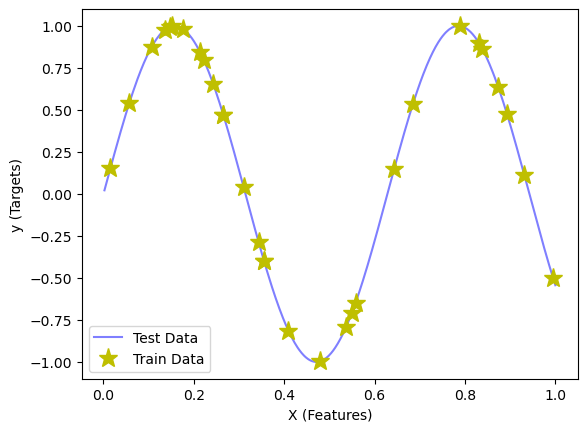

In [2]:
import matplotlib.pyplot as plt

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=14, label='Train Data')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

The following code (thanks to [Parthe Pandit](https://parthe.github.io/)) implements the ReLU NNGP for non-normalized data.  The ```ReLU_NNGP_Kernel``` class provides a scikit-learn like API for using this kernel.

In [3]:
import torch
from numpy.linalg import solve

def relu_nngp(X, Z, depth=2, bias=True):
    from torch import acos
    n, d = X.shape
    pi = np.pi
    kappa_0 = lambda u: (1-acos(u)/pi)
    kappa_1 = lambda u: u*kappa_0(u) + (1-u.pow(2)).sqrt()/pi
    Z = Z if Z is not None else X
    eps = 0
    b = 0
    if bias: 
        b = 1.
    norm_x = X * X + b
    norm_x = torch.clamp(norm_x, min=0.)
    norm_x = torch.sqrt(torch.sum(norm_x, dim=1, keepdim=True))
    norm_z = Z * Z + b
    norm_z = torch.clamp(norm_z, min=0.)
    norm_z = torch.sqrt(torch.sum(norm_z, dim=1, keepdim=True).T)
    S = X @  Z.T + b
    
    for k in range(1, depth):
        in_ = (S/norm_x/norm_z).clip(-1+eps,1-eps)
        S = norm_x*norm_z*kappa_1(in_) 
        S = torch.nan_to_num(S)
    return S


class ReLU_NNGP_Kernel():

    def __init__(self, depth=2, bias=True):
        self.sol = None
        self.depth = depth
        self.X_train = None
        self.bias=bias

    def fit(self, X, y, reg=0):
        self.X_train = torch.from_numpy(X)
        K = relu_nngp(self.X_train, self.X_train, bias=self.bias, depth=self.depth).numpy()
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        X = torch.from_numpy(X)
        K = relu_nngp(self.X_train, X, depth=self.depth, bias=self.bias).numpy()
        return (self.sol @ K).T

Once, we are given a kernel function and input, we just solve kernel regression.  Recall that this involves two steps: (1) Computing the kernel matrix $K(X, X)$ on training data ; and (2) solving kernel regression with $\alpha = y K^{-1}$.

In [4]:
model = ReLU_NNGP_Kernel(depth=2, bias=True)
model.fit(X_train, y_train)
test_pred = model.predict(X_test)

Test R2 Score:  0.9999923052886796


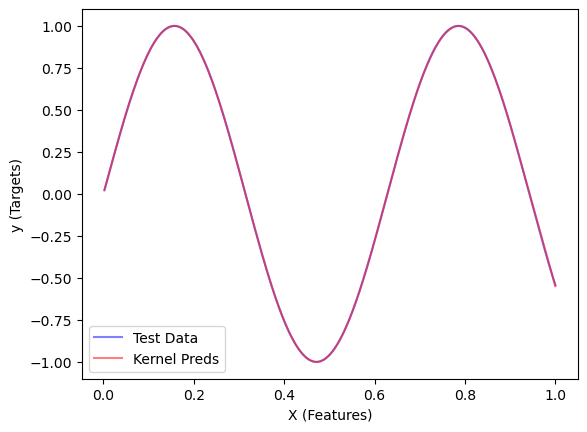

In [5]:
from sklearn.metrics import r2_score

# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

We next evaluate this kernel on a dataset with noise.  Here, using ridge regularization can help avoid fitting noise exactly, leading to better $R^2$ on test samples.   

In [6]:
def sample_noisy_data(n_samples, add_noise=False):
    X = np.random.uniform(size=(n_samples, 1))
    if add_noise:
        noise = np.random.normal(size=(n_samples, 1)) * .5
        y = np.sin(10 * X) + noise
    else:
        y = np.sin(10 * X)
    return X, y    
    
n_train = 30
n_test = 1000
X_train, y_train = sample_noisy_data(n_train, add_noise=True)
X_test, y_test = sample_noisy_data(n_test)

# I will be sorting X_test, y_test so that I can easily visualize the test data as a curve
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))
X_test = np.array(X_test)
y_test = np.array(y_test)

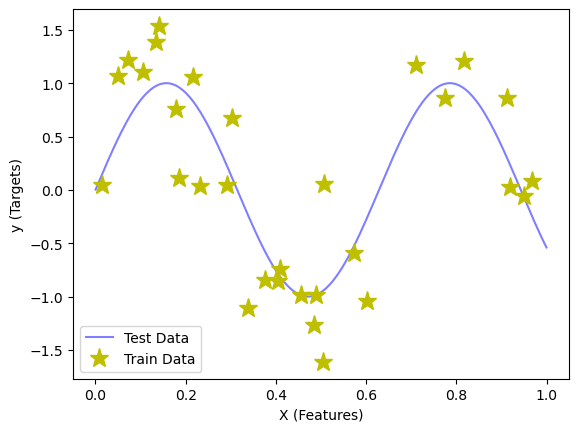

In [7]:
import matplotlib.pyplot as plt

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=14, label='Train Data')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

Test R2 Score:  0.9248092827991272


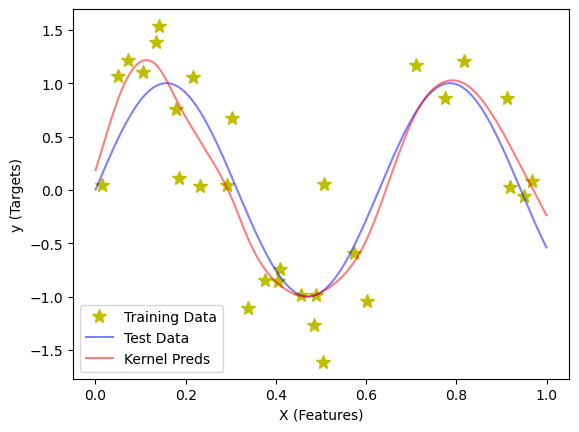

In [9]:
model = ReLU_NNGP_Kernel(depth=2, bias=True)
model.fit(X_train, y_train, reg=1e-4)
test_pred = model.predict(X_test)

# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=10, label='Training Data')
plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()